In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

In [2]:
np.random.seed(0)

In [3]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
train_images = read_idx('./data/train-images.idx3-ubyte')
train_images = train_images.reshape(60000, 28*28)

In [5]:
train_labels = read_idx('./data/train-labels.idx1-ubyte')
one_hot = np.zeros((train_labels.shape[0], 10))
one_hot[np.arange(train_labels.shape[0]), train_labels] = 1
train_labels = one_hot

In [6]:
test_images = read_idx('./data/t10k-images.idx3-ubyte')
test_images = test_images.reshape(10000, 28*28)
test_labels = read_idx('./data/t10k-labels.idx1-ubyte')

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [8]:
class Layer:
    def __init__(self, input_size, size, activation_function, activation_prime, W=None, b=None, init=None):
        self.size = size
        if W == None:
            if init == None:
                self.W = np.random.normal(0, 0.01, (size, input_size))
        else:
            self.W = W
        self.b = np.zeros(size)
        self.error = np.zeros(size)
        self.func = activation_function
        self.func_prime = activation_prime
        
    def predict(self, a):
        self.a_in = a
        self.z = self.b + self.W.dot(a)
        self.a = self.func(self.z)
        return self.a
    
    def backprop(self, learning_rate, W=None, error=None, loss=[]):
        if len(loss) == 0:
            self.error = W.transpose().dot(error) * self.func_prime(self.z)
        else:
            self.error = loss * self.func_prime(self.z)
        self.W -= learning_rate * np.outer(self.error, self.a_in)
        self.b -= self.error

In [28]:
class MLP:
    def __init__(self, input_size, output_size, *layers, learning_rate = 0.0001, batch_size = 100):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        self.hidden_layers = layers
        self.output_layer = Layer(self.hidden_layers[-1].size, self.output_size, np.tanh, lambda x:1-np.tanh(x)**2)
        self.layers = self.hidden_layers + (self.output_layer,)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
    
    def predict(self, a):
        for f in self.layers:
            a = f.predict(a)
        return softmax(a)
    
    def loss(self, x, y):
        return -(y * np.log(self.predict(x))).sum()
    
    def delta_loss(self, x, y):
        return self.predict(x) - y
    
    def train_batch(self, x, y):
        self.output_layer.backprop(self.learning_rate, loss=self.delta_loss(x, y))
        W = self.output_layer.W
        error = self.output_layer.error
        for l in reversed(range(len(self.hidden_layers))):
            self.hidden_layers[l].backprop(self.learning_rate, W, error)
            W = self.hidden_layers[l].W
            error = self.hidden_layers[l].error
            
    def test_train(self, x, y):
        for i in range(60000):
            self.train_batch(x[i], y[i])
            
    def test(self, x, y):
        N = y.shape[0]
        errors = 0
        for i in range(N):
            if np.argmax(mlp.predict(test_images[i])) != test_labels[i]:
                errors += 1
        return errors / N

In [10]:
hl = Layer(28*28, 28*28, np.tanh, lambda x:1-np.tanh(x)**2)

In [11]:
mlp = MLP(28*28, 10, hl)

In [12]:
mlp.test_train(train_images, train_labels)

In [13]:
mlp.test(test_images, test_labels)

0.081

3


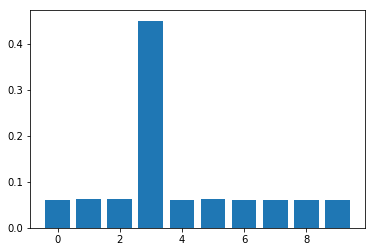

In [35]:
i = 5708
print(test_labels[i])
plt.bar(range(10), mlp.predict(test_images[i]))
plt.show()

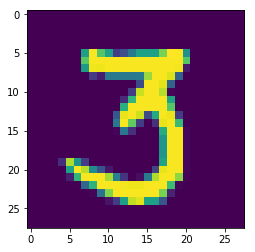

In [36]:
plt.imshow(test_images[i].reshape((28,28)))
plt.show()